# Toy problem

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
import theano.tensor as T

In [2]:
from carl.distributions import Normal
from carl.distributions import Mixture

components = [
    Normal(mu=-2.0, sigma=0.75), 
    Normal(mu=0.0, sigma=2.0), 
    Normal(mu=1.0, sigma=0.25),
]

g = theano.shared(0.1) 
p0 = Mixture(components=components, weights=[0.5 - g/2.0, 0.5 - g/2.0, g])
p1 = Mixture(components=components[:2], weights=[0.5, 0.5])

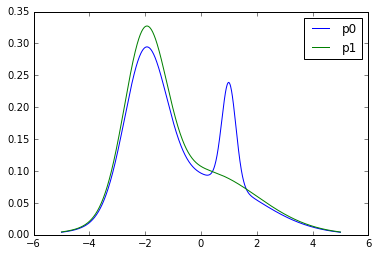

In [3]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p0.pdf(reals.reshape(-1, 1)), label="p0")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label="p1")
plt.legend(loc="best")
plt.show()

# Direct density ratio estimation with backpropagation

$$\min_R V(R) = \mathbb{E}_{x \sim p_1} [\sqrt{R(x)}] + \mathbb{E}_{x \sim p_0} [\frac{1}{\sqrt{R(x)}}] $$

In [4]:
from keras.models import Sequential
from keras.layers.core import Dense
import keras.backend as K

Using Theano backend.


In [5]:
R = Sequential()
R.add(Dense(32, input_dim=1, activation='relu'))
R.add(Dense(32, activation='relu'))
R.add(Dense(32, activation='relu'))
R.add(Dense(1))

In [6]:
n_samples = 50000
X0 = p0.rvs(n_samples=n_samples)
X1 = p1.rvs(n_samples=n_samples)
X = np.vstack((X0, X1))
y = np.zeros(len(X)) 
y[len(X0):] = 1

In [7]:
# Note: we solve for exp(R(x)) so that the solution is log(R(x))
#       in this way, we avoid putting positivity constraints

def loss(y_true, y_pred):
    # Our loss
    return (y_true * (K.sqrt(K.exp(y_pred))) + 
            (1.0 - y_true) * (1.0 / K.sqrt(K.exp(y_pred)))) 

#     # Sugiyama's loss
#     return ((y_true * K.exp(y_pred) ** 2) - 
#              2.0 * (1.0 - y_true) * K.exp(y_pred))

R.compile(loss=loss, optimizer="adam")
R.fit(X, y, nb_epoch=10)

Epoch 1/10
100000/100000 [==============================] - 1s - loss: 0.9950     
Epoch 2/10
100000/100000 [==============================] - 1s - loss: 0.9927     
Epoch 3/10
100000/100000 [==============================] - 1s - loss: 0.9919     
Epoch 4/10
100000/100000 [==============================] - 1s - loss: 0.9916     
Epoch 5/10
100000/100000 [==============================] - 1s - loss: 0.9912     
Epoch 6/10
100000/100000 [==============================] - 1s - loss: 0.9913     
Epoch 7/10
100000/100000 [==============================] - 1s - loss: 0.9911     
Epoch 8/10
100000/100000 [==============================] - 1s - loss: 0.9912     
Epoch 9/10
100000/100000 [==============================] - 1s - loss: 0.9912     
Epoch 10/10
100000/100000 [==============================] - 1s - loss: 0.9912     


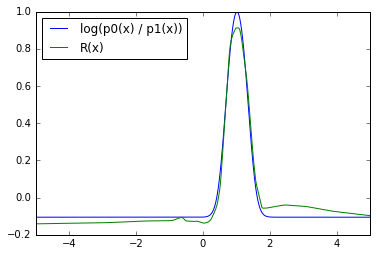

In [9]:
plt.plot(reals, np.log(p0.pdf(reals.reshape(-1, 1)) / 
                       p1.pdf(reals.reshape(-1, 1))), label="log(p0(x) / p1(x))")
plt.plot(reals, R.predict(reals.reshape(-1, 1)), label="R(x)")

plt.xlim(-5, 5)
plt.legend(loc="best")
plt.show()

Bim!